## Installation des librairies

In [33]:
#!pip install torch
#!pip install grad-cam
#!pip install opencv-python
#!pip install opencv-python-headless
#!pip install seaborn
!pip install pandas

## Importation des différentes librairies et vérification de la précense du gpu sur la machine

In [35]:
local_path  = 'data/car_data/car_data'
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
import time
import os
import PIL.Image as Image
from IPython.display import display
from torchvision.models import resnet18, ResNet18_Weights
from pytorch_grad_cam import GradCAM
from sklearn.metrics import confusion_matrix, classification_report
from pytorch_grad_cam.utils.image import show_cam_on_image
import cv2  # Importer OpenCV pour le redimensionnement

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cuda


## Affichage de la répartition des voiitures par classes 

In [6]:
car_count_dict = {}
for folder_name in os.listdir(os.path.join(local_path, 'train')):
    count = len(os.listdir(os.path.join(local_path, 'train', folder_name)))
    car_count_dict[folder_name] = count

for folder_name in os.listdir(os.path.join(local_path, 'test')):
    count = len(os.listdir(os.path.join(local_path, 'test', folder_name)))
    car_count_dict[folder_name] += count

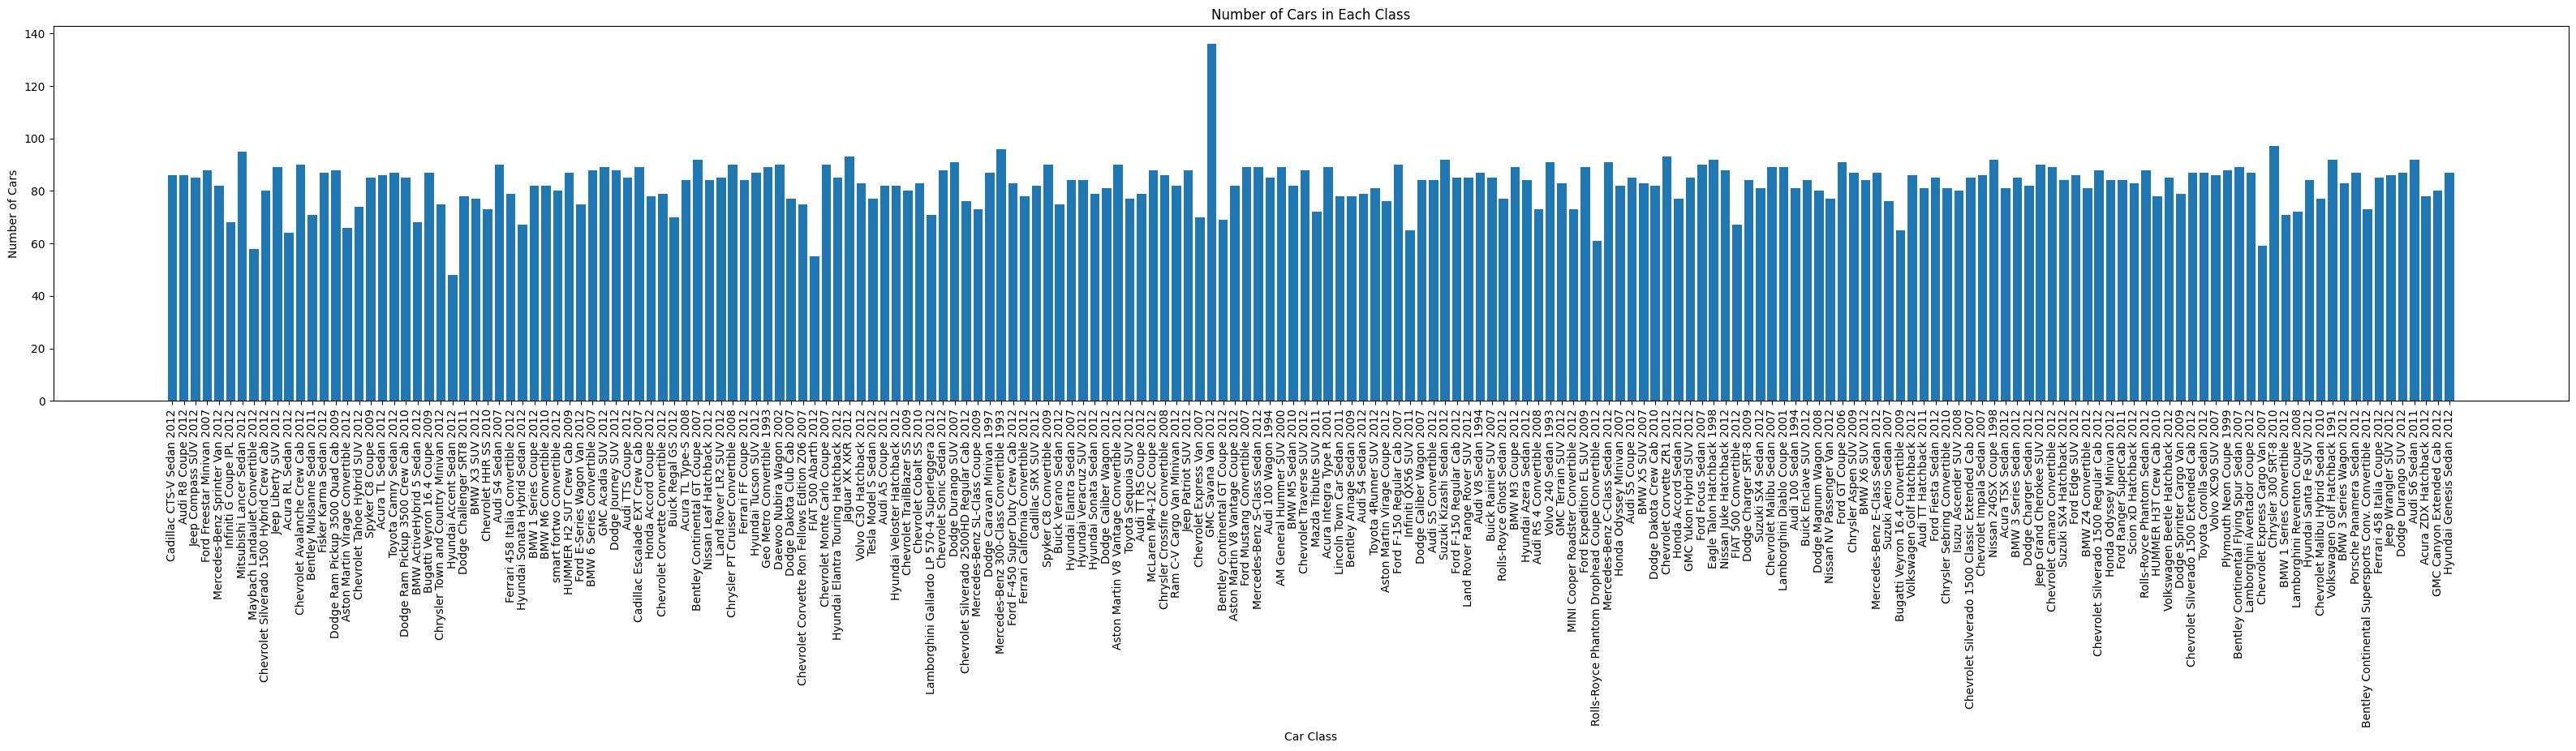

<Figure size 640x480 with 0 Axes>

In [7]:
plt.figure(figsize=(40, 6))
    # Creéation d'un graphique en barre
plt.bar(car_count_dict.keys(), car_count_dict.values())


plt.xlabel('Car Class')
plt.ylabel('Number of Cars')
plt.title('Number of Cars in Each Class')

plt.xticks(rotation=90)

plt.show()
plt.savefig('image.png')

In [8]:
dataset_dir = local_path
# augmentation du jeu de donnée pour éviter l'overfitting
train_tfms = transforms.Compose([transforms.Resize((400, 400)),
                                transforms.RandomHorizontalFlip(),
                                transforms.RandomRotation(15),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
test_tfms = transforms.Compose([transforms.Resize((400, 400)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
test_time_tfms = transforms.Compose([transforms.Resize((400, 400)),
                                transforms.ToTensor(),
                                transforms.RandomRotation(90),
                                transforms.RandomHorizontalFlip(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_dataset = torchvision.datasets.ImageFolder(root=os.path.join(dataset_dir, 'train'), transform = train_tfms)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 32, shuffle=True, num_workers = 2)

test_dataset = torchvision.datasets.ImageFolder(root=os.path.join(dataset_dir, 'test'), transform = test_tfms)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 32, shuffle=False, num_workers = 2)

## Affichage des images augmentées

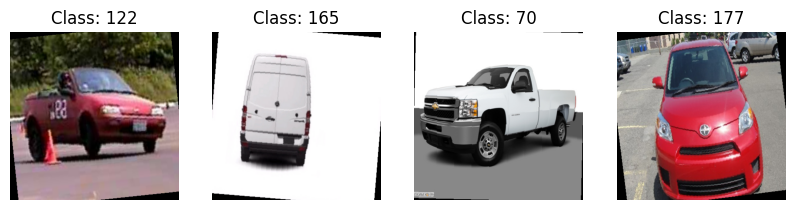

In [31]:
def show_images(images, labels):
    fig, axes = plt.subplots(nrows=1, ncols=len(images), figsize=(10, 4))
    for ax, image, label in zip(axes, images, labels):
        image = image.numpy().transpose((1, 2, 0))  
        mean = np.array([0.5, 0.5, 0.5])
        std = np.array([0.5, 0.5, 0.5])
        image = std * image + mean

        ax.imshow(image)
        ax.set_title(f'Class: {label}')
        ax.axis('off')

    plt.show()
images, labels = next(iter(train_loader))
show_images(images[:4], labels[:4])

## Chargement du modèle

In [12]:
model = resnet18(weights=ResNet18_Weights.DEFAULT)
num_ftrs = model.fc.in_features
# affichage du nombre de classes 
no_classes = len(train_dataset.classes)
# Affichage de l'architecture du modèle
model.parameters

<bound method Module.parameters of ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


In [14]:
model.fc = nn.Linear(num_ftrs, no_classes)
model = model.to(device)

# définition de la log fonctio de de l'optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
lrscheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, threshold = 0.9)

In [15]:
## Définition de la fonction train_model()

In [16]:
def train_model(model, train_loader, test_loader, criterion, optimizer, scheduler, device, n_epochs = 5):
    losses = []
    accuracies = []
    test_accuracies = []
    model.train()
    # Itération sur chaque epoch
    for epoch in tqdm(range(n_epochs)):
        # sauvegarde le temps de chaque epoch
        since = time.time()
        running_loss = 0.0
        running_correct = 0.0
        # iteration sur le train set
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            # calcule de la loss
            running_loss += loss.item()
            # calcul de l'accuracy
            running_correct += (labels==predicted).sum().item()
        epoch_duration = time.time()-since
        epoch_loss = running_loss/len(train_loader)
        epoch_acc = 100/32*running_correct/len(train_loader)
        print("Epoch %s, duration: %d s, loss: %.4f, acc: %.4f" % (epoch+1, epoch_duration, epoch_loss, epoch_acc))
        losses.append(epoch_loss)
        accuracies.append(epoch_acc)
        # Evaluation du modèle sur le test
        model.eval()
        test_acc = eval_model(model, test_loader, device)
        test_accuracies.append(test_acc)
        model.train()
        scheduler.step(test_acc)
        since = time.time()
    print('Finished Training')
    return model, losses, accuracies, test_accuracies

## Evalutation du modèle

In [17]:
def eval_model(model, test_loader, device, test_time_tsfm=None, num_augmentations=1):
    correct = 0.0
    total = 0.0
    with torch.no_grad():
        for i, data in enumerate(test_loader, 0):
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            if test_time_tsfm is not None:
                augmented_images = []
                for img in images:
                    augmented_images.extend(img)
                    # Application de la transoformation aux images 
                    augmented_imgs = [test_time_tsfm(img) for _ in range(num_augmentations)]
                    augmented_images.extend(augmented_imgs)
                images = torch.stack(augmented_images)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0) * num_augmentations
            # Nombre des prédictions totales
            correct += (predicted == labels.repeat(num_augmentations)).sum().item()
    # Calcul de la précision
    test_acc = 100.0 * correct / total
    print('Accuracy of the network on the test images: %d %%' % (
        test_acc))
    return test_acc

In [35]:
#Code à décommenter si on veut entrainer le modèle
#n_epochs = 10
# train the model
#model, training_losses, training_accs, test_accs = train_model(model, train_loader, 
                            #test_loader, criterion, optimizer, lrscheduler, device, n_epochs=n_epochs)
# Save the model
#torch.save(model.state_dict(), 'model.pth')

In [18]:
#affichage de l'évolution de la training loss et de la training accuracy après l'entrainement
'''fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Plot training loss
axs[0].plot(training_losses)
axs[0].set_title("Training Loss")

# Plot training and test accuracy
axs[1].plot(training_accs, label="Training Accuracy")
axs[1].plot(test_accs, label="Test Accuracy")
axs[1].set_title("Training and Test Accuracy")
axs[1].legend()

plt.tight_layout()
plt.show()'''

'fig, axs = plt.subplots(1, 2, figsize=(12, 4))\n\n# Plot training loss\naxs[0].plot(training_losses)\naxs[0].set_title("Training Loss")\n\n# Plot training and test accuracy\naxs[1].plot(training_accs, label="Training Accuracy")\naxs[1].plot(test_accs, label="Test Accuracy")\naxs[1].set_title("Training and Test Accuracy")\naxs[1].legend()\n\nplt.tight_layout()\nplt.show()'

In [19]:
def find_classes(dir):
    classes = os.listdir(dir)
    classes.sort()
    class_to_idx = {classes[i]: i for i in range(len(classes))}
    return classes, class_to_idx
classes, c_to_idx = find_classes(os.path.join(dataset_dir, 'train'))

## Codage d'une heatmap

In [20]:
model.load_state_dict(torch.load('model.pth'))
model.eval()

""" 
transforms for the input image (this is not the test loader) This is just for a single image to be the same size and
normalized as the test loader 
"""
loader = transforms.Compose([transforms.Resize((400, 400)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

random_image_name = 'Aston Martin Virage Coupe 2012/00757.jpg'
image = Image.open(os.path.join(dataset_dir, 'test', random_image_name))
# Affichage de l'image prédit 
image = loader(image).float()
image = torch.autograd.Variable(image, requires_grad=True)
image = image.unsqueeze(0)
image = image.cuda()
start_time = time.time()

output = model(image)

# Mesurer le temps après l'inférence
end_time = time.time()

# Calculer le temps écoulé pour l'inférence
inference_time = end_time - start_time
 
conf, predicted = torch.max(output.data, 1)

# Afficher le temps d'inférence
print("Temps d'inférence:", inference_time, "secondes")

Temps d'inférence: 8.865071058273315 secondes


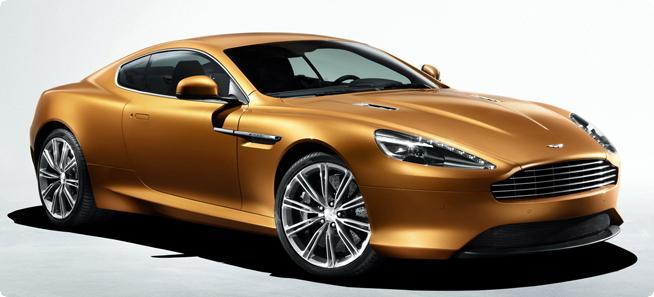

Aston Martin Virage Coupe 2012 confidence:  14.416361808776855


In [21]:
display(Image.open(os.path.join(dataset_dir, 'test', random_image_name)))
print(classes[predicted.item()], "confidence: ", conf.item())

In [23]:
true_labels = []
predicted_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        
        # Obtention des labels prédit
        _, predicted = torch.max(outputs.data, 1)
        
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

# Génération de la matrice de confusion
cm = confusion_matrix(true_labels, predicted_labels)

#Affichage de la précision et du rappel
cr = classification_report(true_labels, predicted_labels)

print("Confusion Matrix:")
print(cm)
print("\nClassification Report:")
print(cr)

Confusion Matrix:
[[42  0  0 ...  0  0  0]
 [ 0 42  0 ...  0  0  0]
 [ 0  0 27 ...  0  0  0]
 ...
 [ 0  0  0 ... 38  0  0]
 [ 0  0  0 ...  0 42  0]
 [ 0  0  0 ...  0  0 38]]

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95        44
           1       0.93      0.95      0.94        44
           2       0.68      0.84      0.75        32
           3       0.84      0.98      0.90        43
           4       0.95      0.95      0.95        42
           5       0.97      0.82      0.89        40
           6       0.90      0.90      0.90        39
           7       0.80      0.80      0.80        45
           8       0.79      0.73      0.76        41
           9       0.87      0.82      0.84        33
          10       0.77      0.87      0.81        38
          11       0.68      0.75      0.71        40
          12       0.76      0.81      0.78        42
          13       0.76      0.85      0.80  

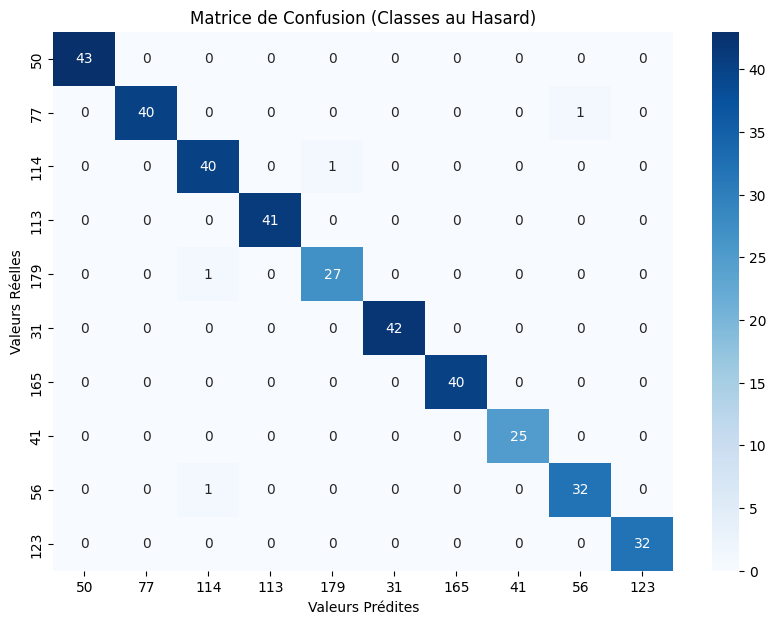

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

# Sélection de 10 classes au hasard
random_classes = np.random.choice(range(196), size=10, replace=False)

# Création de la matrice de confusion pour ces classes
subset_cm = cm_df.iloc[random_classes, random_classes]

# Configuration de la taille du graphique
plt.figure(figsize=(10, 7))

# Création de la heatmap
sns.heatmap(subset_cm, annot=True, cmap='Blues', fmt='g')

# Ajout de labels et de titre
plt.xlabel('Valeurs Prédites')
plt.ylabel('Valeurs Réelles')
plt.title('Matrice de Confusion (Classes au Hasard)')

# Affichage du graphique
plt.show()

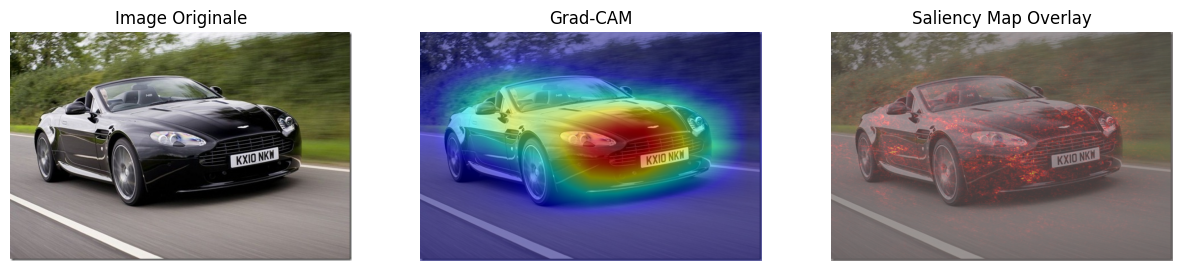

In [24]:
model.load_state_dict(torch.load('model.pth'))
model.eval()
model.cuda()
# Initialiser Grad-CAM
target_layers = [model.layer4[-1]]
cam = GradCAM(model=model, target_layers=target_layers)

# Préparer l'image
loader = transforms.Compose([
    transforms.Resize((400, 400)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
image_path = os.path.join(dataset_dir, 'test', 'Aston Martin V8 Vantage Convertible 2012/01633.jpg')
img = Image.open(image_path)
original_img = np.array(img)  # Convertir en array numpy pour faciliter le traitement
img_tensor = loader(img).unsqueeze(0).cuda()  # Assurer que le tensor est sur CUDA

# Calcul de la Grad-CAM
grayscale_cam = cam(input_tensor=img_tensor, eigen_smooth=False)
grayscale_cam = grayscale_cam[0, :]  # Extraction pour la première image
grayscale_cam_resized = cv2.resize(grayscale_cam, (original_img.shape[1], original_img.shape[0]))
visualization = show_cam_on_image(original_img/255.0, grayscale_cam_resized, use_rgb=True)

# Calculer la Saliency Map
img_tensor.requires_grad = True
output = model(img_tensor)
score, index = torch.max(output, 1)
score.backward()
saliency, _ = torch.max(img_tensor.grad.data.abs(), dim=1)
saliency = saliency.reshape(400, 400)
saliency = cv2.resize(saliency.cpu().data.numpy(), (original_img.shape[1], original_img.shape[0]))

# Affichage des résultats
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(original_img)
plt.title("Image Originale")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(visualization)
plt.title("Grad-CAM")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(original_img, alpha=0.6)
plt.imshow(saliency, cmap='hot', alpha=0.4)
plt.title("Saliency Map Overlay")
plt.axis('off')

plt.show()
